# Загрузка

In [1]:
targets = ['Врем. сопротивление', 'Предел текучести']

In [16]:
ls_need_col = ['Врем. сопротивление', 'Предел текучести',
       'Тип предела текучести (1186)',
       '1 зона по ВТР закалка',
       '2 зона по ВТР закалка',
       '3 зона по ВТР закалка',
       'Скорость прохождения трубы через спрейер, м/с',
       't˚ C трубы после спреера',
       '1 зона ВТР и уставка отпуск', 
       '2 зона ВТР и уставка отпуск',
       '3 зона ВТР и уставка отпуск',
       '4 зона ВТР и уставка отпуск',
       '5 зона ВТР и уставка отпуск',
       'диаметр', 
       'марка стали',
       'толщина стенки', 
       'шаг балок закалочная печь, сек',
       'шаг балок отпускная печь, сек',
       'C', 'Mn', 'Si', 'P', 'S',
       'Cr', 'Ni', 'Cu', 'Al', 'V', 'Ti', 'Nb', 'Mo', 'N',
       'ICD',
       'C-coef', 'Параметр закалка', 'Параметр отпуск',
       'Параметр отпуск новый', 'Параметр отпуск новый 2',
       'Параметр отпуск новый V',
       'Величина зерна']

In [4]:
import pandas as pd
import numpy as np
import import_ipynb
from my_libs.calc_features import *
import random
from datetime import datetime

importing Jupyter notebook from C:\Users\kseniya.yuldasheva\Desktop\gitPNTZtoyuk_1\gitPNTZ\PNTZ\my_libs\calc_features.ipynb


In [5]:
pd.options.display.max_columns = 500
pd.options.display.max_rows = 1000

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [34]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, matthews_corrcoef, median_absolute_error
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, ExtraTreesRegressor
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_predict, cross_validate, train_test_split, GridSearchCV
from sklearn import model_selection
import matplotlib.pyplot as plt
import os
from time import time
from datetime import datetime
from my_libs.save_lib import save_RF_model

In [8]:
df = pd.read_excel('DATA/prepared/prepared_hard.xlsx')

In [53]:
df_valid = pd.read_excel('DATA/prepared/prepared_hard_valid.xlsx')

# Отделение данных с ванной

In [70]:
df = df[df['время выдержки в закалочной ванне, сек.'].isnull()].copy()
df_valid = df_valid[df_valid['время выдержки в закалочной ванне, сек.'].isnull()].copy()

In [71]:
df.shape, df_valid.shape

((21823, 211), (1580, 200))

In [12]:
df.reset_index(inplace=True, drop=True)
df_valid.reset_index(inplace=True, drop=True)

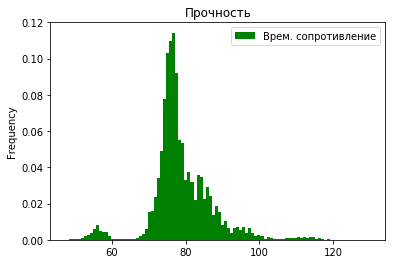

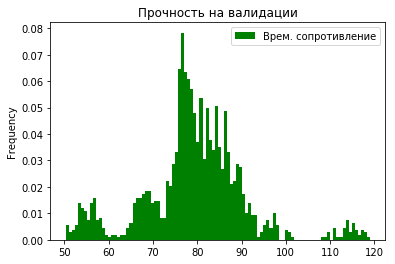

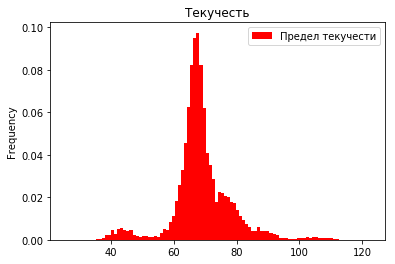

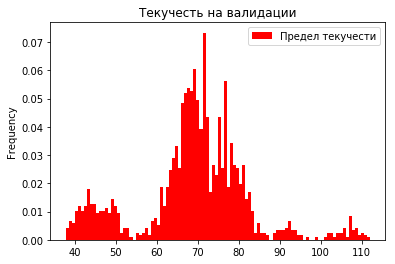

In [14]:
df.plot(y='Врем. сопротивление', kind='hist', color='green', title='Прочность', bins=100, density=True)
df_valid.plot(y='Врем. сопротивление', kind='hist', color='green', title='Прочность на валидации', bins=100, density=True)
df.plot(y='Предел текучести', kind='hist', color='red', title='Текучесть', bins=100, density=True)
df_valid.plot(y='Предел текучести', kind='hist', color='red', title='Текучесть на валидации', bins=100, density=True)
plt.show()

# Обучение

In [17]:
ls_train_col = ls_need_col.copy()
for s in targets+['марка стали']:
    ls_train_col.remove(s) 

In [72]:
df_clean = df[ls_train_col+targets].dropna()
df_valid_clean = df_valid[ls_train_col+targets].dropna()

In [73]:
df_clean.shape, df_valid_clean.shape

((20927, 39), (1466, 39))

In [74]:
X = df_clean[ls_train_col]
y = df_clean[targets]
X_valid = df_valid_clean[ls_train_col]
y_valid = df_valid_clean[targets]

In [21]:
def print_and_return_score(x, y, est):
    y_pred = est.predict(x)
    scr = est.score(x, y)
    mae = mean_absolute_error(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    corr = []
    for i in range(y.columns.size):
        corr.append(np.corrcoef(y.iloc[:, i].T, 
                                y_pred[:, i]))
        
    print('Score: ', round(scr, 2))
    print('R^2: ', round(r2, 2))
    print('MAE: ', round(mae, 2))
    print('MSE: ', round(mse, 2))
    print('Correlation Врем. сопротивление: ', round(corr[0][0][1], 2))
    print('Correlation Предел текучести: ', round(corr[1][0][1], 2))
    return [scr, mae, mse, corr[0][0][1], corr[1][0][1]]

In [22]:
X_train, X_test,  y_train, y_test = train_test_split(X, y, test_size=0.3)

rfc = RandomForestRegressor(max_features = 10, max_depth = 15, min_samples_leaf = 2, n_estimators=100, criterion='mse')
rfc.fit(X_train, y_train)

scr, mae, mse, corr1, corr2 = print_and_return_score(X_test, y_test, rfc)

Score:  0.89
R^2:  0.89
MAE:  2.0
MSE:  8.47
Correlation Врем. сопротивление:  0.95
Correlation Предел текучести:  0.93


In [23]:
score_df = pd.concat([pd.DataFrame({'Score':[scr], 'MAE':[mae], 'MSE':[mse], 'Correlation Врем. сопротивление':[corr1],
                                                     'Correlation Предел текучести':[corr2]}),
                      pd.DataFrame(rfc.predict(X_valid), columns=['прогноз Врем. сопротивление', 'прогноз Предел текучести']),
                      y_valid],
                    axis=1)

In [24]:
save_RF_model(rfc, ls_train_col, 'H+YS without bath', score_df)

Модель сохранена


## GridSearchCV

In [25]:
param_grid = {
    'max_depth': range(6, 18, 2),
    'max_features': range(6, 18, 2),
    'min_samples_leaf': range(1, 5),
    'n_estimators': range(50, 300, 50)
}

rf = RandomForestRegressor()

grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2, scoring='neg_mean_absolute_error')

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [27]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 720 candidates, totalling 2160 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   42.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed: 11.4min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed: 16.8min
[Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed: 19.7min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': range(6, 18, 2), 'max_features': range(6, 18, 2), 'min_samples_leaf': range(1, 5), 'n_estimators': range(50, 300, 50)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=2)

In [28]:
grid_search.best_params_

{'max_depth': 16,
 'max_features': 16,
 'min_samples_leaf': 2,
 'n_estimators': 200}

In [29]:
scr, mae, mse, corr, y_pred = print_and_return_score(X_test, y_test, grid_search)

Score:  -1.99
R^2:  0.9
MAE:  1.99
MSE:  8.26
Correlation Врем. сопротивление:  0.96
Correlation Предел текучести:  0.94


In [30]:
y_predict = grid_search.predict(X_test)

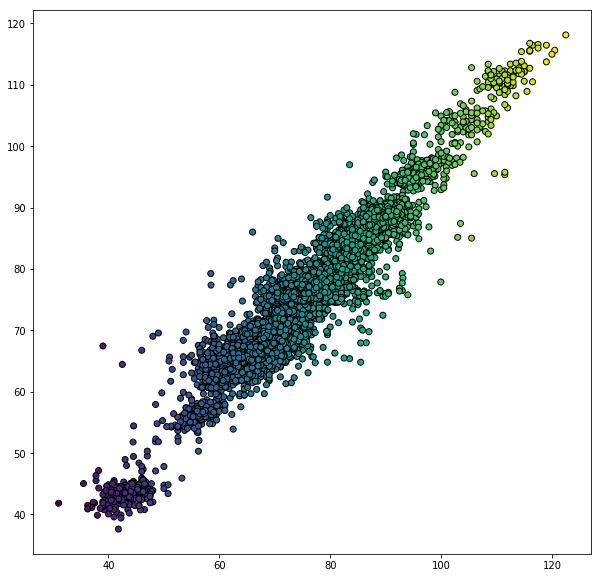

In [31]:
plt.subplots(figsize=(10,10))
plt.scatter(y_test, y_predict, marker='o', c=y_test, edgecolors='black', cmap='viridis')
# plt.colorbar()
plt.show()

## Cross-validation with KFold

In [35]:
kfold = model_selection.KFold(n_splits=5, shuffle=True)
scores = []
for train, test in kfold.split(X, y):
    x_train, y_train = X.iloc[train], y.iloc[train]
    x_test, y_test = X.iloc[test], y.iloc[test]
    grf = grid_search.best_estimator_
    grf.fit(x_train, y_train)

    scores.append(print_and_return_score(X_valid, y_valid, grf))

Score:  0.89
R^2:  0.89
MAE:  2.92
MSE:  15.85
Correlation Врем. сопротивление:  0.96
Correlation Предел текучести:  0.94
Score:  0.89
R^2:  0.89
MAE:  2.94
MSE:  16.47
Correlation Врем. сопротивление:  0.96
Correlation Предел текучести:  0.94
Score:  0.88
R^2:  0.89
MAE:  2.95
MSE:  16.65
Correlation Врем. сопротивление:  0.96
Correlation Предел текучести:  0.94
Score:  0.89
R^2:  0.89
MAE:  2.93
MSE:  15.75
Correlation Врем. сопротивление:  0.96
Correlation Предел текучести:  0.94
Score:  0.89
R^2:  0.89
MAE:  2.94
MSE:  15.96
Correlation Врем. сопротивление:  0.96
Correlation Предел текучести:  0.94


In [36]:
for i in range(5):
    tmp = []
    for j in range(5):
        tmp.append(scores[j][i])
    print(round(np.mean(tmp), 2))

0.89
2.94
16.13
0.96
0.94


In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
grf = grid_search.best_estimator_
grf.fit(X_train, y_train)
scr, mae, mse, corr1, corr2 = print_and_return_score(X_test, y_test, grf)

Score:  0.89
R^2:  0.89
MAE:  1.95
MSE:  8.15
Correlation Врем. сопротивление:  0.96
Correlation Предел текучести:  0.93


In [66]:
''' Проверка на 147 строчках ванны '''

# df_valid = pd.read_excel('DATA/prepared/prepared_hard_valid.xlsx')

# def bath2spr(df):
#     L = 8.4
#     df['Скорость прохождения трубы через спрейер, м/с'] = L/df['время выдержки в закалочной ванне, сек.']
#     df['t˚ C трубы после спреера'] = df['t˚ C трубы после ванны']
#     return df

# bath_valid = df_valid[~df_valid['время выдержки в закалочной ванне, сек.'].isnull()].copy()

# bath_valid = bath2spr(bath_valid) 

# bath_valid_ = bath_valid.dropna() 
# X_valid = bath_valid_[ls_train_col]
# y_valid = bath_valid_[targets]

In [75]:
X_valid.shape

(1466, 37)

In [68]:
y_pred = pd.DataFrame(grf.predict(X_valid), columns=['прогноз Врем. сопротивление', 'прогноз Предел текучести'])
y_pred.reset_index(inplace=True, drop=True)
y_valid.reset_index(inplace=True, drop=True)

scr, mae, mse, corr1, corr2 = print_and_return_score(X_valid, y_valid, grf)

score_df = pd.concat([pd.DataFrame({'Score':[scr], 'MAE':[mae], 'MSE':[mse], 'Correlation Врем. сопротивление':[corr1],
                                                     'Correlation Предел текучести':[corr2]}),
                      y_pred,
                      y_valid],
                    axis=1)

score_df['MAE Предел текучести'] = np.abs(score_df['Предел текучести'] - score_df['прогноз Предел текучести'])
score_df['MAE Врем. сопротивление'] = np.abs(score_df['Врем. сопротивление'] - score_df['прогноз Врем. сопротивление'])

Score:  0.4
R^2:  0.41
MAE:  3.89
MSE:  21.75
Correlation Врем. сопротивление:  0.86
Correlation Предел текучести:  0.85


In [49]:
save_RF_model(grf, ls_train_col, 'H+YS without Bath GS', score_df)

Модель сохранена
